In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import pandas as pd
import seaborn as sns
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
from src.noises import *
from src.datasets import *
from src.smooth import *
from src.models import WideResNet

sns.set_context("notebook", rc={"lines.linewidth": 2})
sns.set_style("whitegrid")
sns.set_palette("husl")

In [3]:
dim = 100

for noise_str in ("Gaussian", "Laplace", "Uniform"):

    noise = eval(noise_str)(lambd=1.0, dim=dim)

    rvs = noise.sample(torch.zeros(10000, dim))
    l2_norms = rvs.norm(p=2, dim=1) / np.sqrt(dim)
    
    print(f"{noise_str}:\tempirical sigma estimate = {l2_norms.mean():.2f};\ttheoretical sigma = {noise.sigma:.2f}")

Gaussian:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Laplace:	empirical sigma estimate = 1.41;	theoretical sigma = 1.41
Uniform:	empirical sigma estimate = 0.58;	theoretical sigma = 0.58


In [4]:
for noise_str in ("Gaussian", "Laplace", "Uniform"):

    noise = eval(noise_str)(sigma=1.0, dim=dim)

    rvs = noise.sample(torch.zeros(10000, dim))
    l2_norms = rvs.norm(p=2, dim=1).pow(2) / dim
    
    print(f"{noise_str}:\tempirical sigma estimate = {l2_norms.mean():.2f};\ttheoretical sigma = {noise.sigma:.2f}")

Gaussian:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Laplace:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Uniform:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00


In [5]:
dataset = get_dataset("cifar", "test")
dim = get_dim("cifar")

x, y = dataset[1]
sigmas = [0.0, 0.15, 0.25, 0.5, 0.75]

def plot_image(x):
    plt.imshow(x.numpy().transpose(1, 2, 0))

Files already downloaded and verified


C:\Users\sange\Documents\rs4a-master\rs4a-master\src\noises\noises.py:95: UserWarning: No direct robustness guarantee for l0; converting l1, linf radii to l0.
  warnings.warn(f'No direct robustness guarantee for l{adv}; '


(0.0, 3.0)

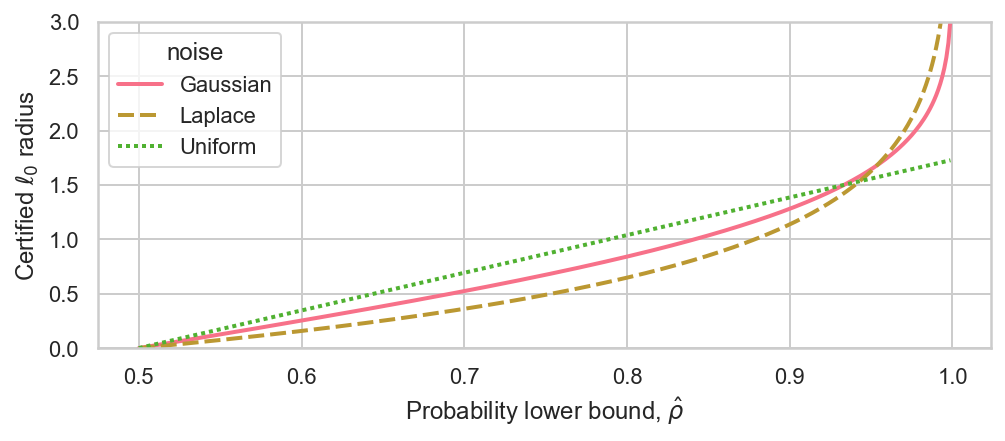

In [36]:
axis = np.linspace(0.5, 1.0, 400, endpoint=False)

df = defaultdict(list)

for noise_str in ["Gaussian", "Laplace", "Uniform"]:

    noise = eval(noise_str)(sigma=1.0, dim=dim)
    radii = noise.certify(torch.tensor(axis), adv=0).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise_str] * len(axis)

df = pd.DataFrame(df)
plt.figure(figsize=(8, 3))
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df)
plt.xlabel("Probability lower bound, $\\hat\\rho$")
plt.ylabel("Certified $\ell_0$ radius")
plt.ylim((0, 3))

In [8]:
map_location=torch.device('cpu')

In [ ]:
model = WideResNet(dataset="cifar", device="cpu")
saved_dict = torch.load("./train/cifar_laplace_050.pt",map_location)
model.load_state_dict(saved_dict)
model.eval();

: 

In [108]:
noise = Laplace(device="cpu", dim=3072, sigma=0.5)

preds = smooth_predict_hard(model, x, noise, 256)
print("Predictions:", preds.probs.cpu().numpy().round(2))

Predictions: [[0.   0.   0.   0.04 0.3  0.   0.66 0.   0.   0.  ]]


Using the top class that we found using 256 samples (i.e. frog), we now take 100,000 samples to compute $\hat \rho_\mathrm{lower}$ for that class.

In [109]:
top_cats = preds.probs.argmax(dim=1)
prob_lb = certify_prob_lb(model, x, top_cats, 0.001, noise, 100)
print(f"Probability lower bound: {prob_lb:.2f}")

Probability lower bound: 0.52


In [110]:
radius = noise.certify(prob_lb, adv=2)
print(f"Certified Robust L2 Radius for Lalace: {radius:.2f}")

Certified Robust L2 Radius for Lalace: 0.00


C:\Users\sange\Documents\rs4a-master\rs4a-master\src\noises\noises.py:95: UserWarning: No direct robustness guarantee for l2; converting l1, linf radii to l2.
  warnings.warn(f'No direct robustness guarantee for l{adv}; '


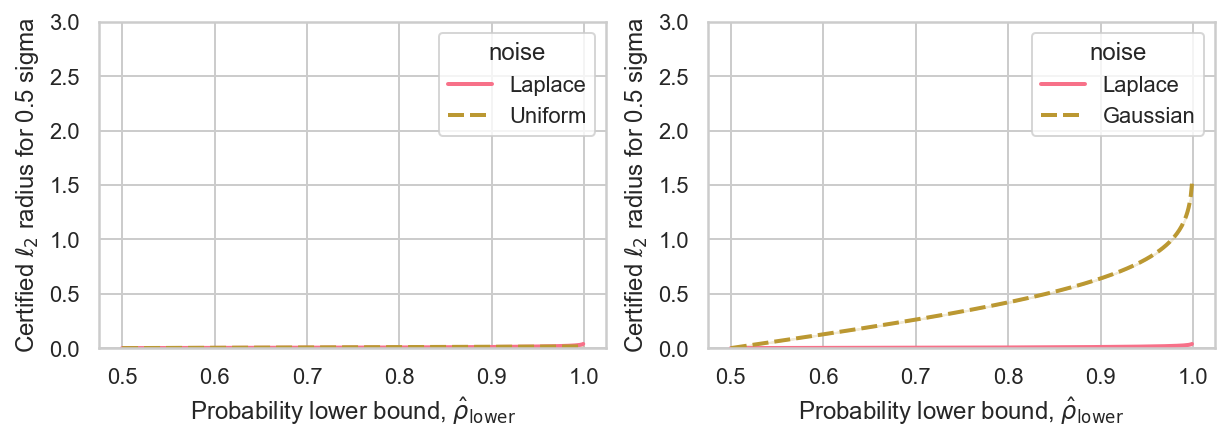

In [94]:
df = defaultdict(list)

noise = Laplace(sigma=0.5, dim=dim)
radii = noise.certify(torch.tensor(axis), adv=2).numpy()
df["radius"] += radii.tolist() * 2
df["axis"] += axis.tolist() * 2
df["noise"] += ["Laplace"] * len(axis) * 2 
df["set"] += ["pow"] * len(axis) 
df["set"] += ["exp"] * len(axis) 

for j in (dim - 2, dim - 10, dim - 100):
    
    noise = Uniform(sigma=0.5, dim=3072)
    radii = noise.certify(torch.tensor(axis), adv=2).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["exp"] * len(axis)
    
for a in (dim + 3, dim + 10, dim + 100):

    noise = Gaussian(sigma=0.5, dim=dim)
    radii = noise.certify(torch.tensor(axis), adv=2).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["pow"] * len(axis)

df = pd.DataFrame(df)
plt.figure(figsize=(10, 3))
for i, key in enumerate(("exp", "pow")):
    plt.subplot(1, 2, i + 1)
    sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df[df["set"] == key])
    plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
    plt.ylabel("Certified $\ell_2$ radius for 0.5 sigma")
    plt.ylim((0, 3))